<a href="https://colab.research.google.com/github/parashac/Violence-Detection-using-CCTV-footage/blob/main/weapon_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import glob
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, BatchNormalization,
    GlobalAveragePooling2D, Dense, Dropout
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:

def load_weapon_dataset(image_dir, label_dir):
    X, y = [], []

    image_files = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))

    for img_path in image_files:
        img = cv2.imread(img_path)
        if img is None:
            continue

        h, w = img.shape[:2]

        xml_path = os.path.join(
            label_dir,
            os.path.basename(img_path).replace(".jpg", ".xml")
        )

        if not os.path.exists(xml_path):
            continue

        bbox = parse_weapon_xml(xml_path, w, h)
        if bbox is None:
            continue

        X.append(preprocess_frame(img))
        y.append(bbox)

    return np.array(X, dtype="float32"), np.array(y, dtype="float32")


In [ ]:
def parse_weapon_xml(xml_file, img_width, img_height):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    obj = root.find("object")
    if obj is None:
        return None

    bbox = obj.find("bndbox")
    if bbox is None:
        return None

    xmin = float(bbox.find("xmin").text)
    ymin = float(bbox.find("ymin").text)
    xmax = float(bbox.find("xmax").text)
    ymax = float(bbox.find("ymax").text)

    # Normalize to 0–1
    x_center = ((xmin + xmax) / 2) / img_width
    y_center = ((ymin + ymax) / 2) / img_height
    w = (xmax - xmin) / img_width
    h = (ymax - ymin) / img_height

    return [x_center, y_center, w, h]

In [ ]:
IMAGE_SIZE = 224

def preprocess_frame(img):
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = img.astype("float32") / 255.0
    return img
def augment(img, y):
    # img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.2)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    return img, y


In [ ]:
TRAIN_IMG_DIR = "/content/drive/My Drive/violencee/violence-detection/weapon/weapon_split/train/images"
TRAIN_LBL_DIR = "/content/drive/My Drive/violencee/violence-detection/weapon/weapon_split/train/labels"

VAL_IMG_DIR = "/content/drive/My Drive/violencee/violence-detection/weapon/weapon_split/val/images"
VAL_LBL_DIR = "/content/drive/My Drive/violencee/violence-detection/weapon/weapon_split/val/labels"

X_train, y_train = load_weapon_dataset(TRAIN_IMG_DIR, TRAIN_LBL_DIR)
X_val, y_val = load_weapon_dataset(VAL_IMG_DIR, VAL_LBL_DIR)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)


Train: (1256, 224, 224, 3) (1256, 4)
Val: (236, 224, 224, 3) (236, 4)


In [ ]:
# X, y = load_weapon_dataset(image_dir, label_dir)

# if len(X) == 0:
#     print("Error: No images or labels were loaded. Please check the image_dir and label_dir paths and their contents.")
# else:
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#     print(f" Total Images: {len(X)}")
#     print(f" Training: {len(X_train)}, Validation: {len(X_val)}")

In [ ]:

def build_weapon_detector():
    base = MobileNetV2(
        input_shape=(224,224,3),
        include_top=False,
        weights="imagenet"
    )
    base.trainable = False  # fine-tune later

    model = Sequential([
        base,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(256, activation="relu"),
        Dropout(0.4),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(4, activation="sigmoid")  # x,y,w,h
    ])
    return model

model = build_weapon_detector()

model.compile(
    optimizer=Adam(1e-4),
    loss=tf.keras.losses.Huber(),
    metrics=["mae"]
)

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,624,452 (10.01 MB)

 Trainable params: 363,908 (1.39 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [ ]:
CHECKPOINT_DIR = "/content/drive/My Drive/violence-detection/checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(
        CHECKPOINT_DIR,
        "weapon_epoch_{epoch:02d}_valLoss_{val_loss:.4f}.keras"
    ),
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True,
    verbose=1
)


In [ ]:
lr_reduce = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=4,
    min_lr=1e-6,
    verbose=1
)


In [ ]:
history1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=16,
    callbacks=[checkpoint_callback, early_stop, lr_reduce],
    verbose=1
)


Epoch 1/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.0433 - mae: 0.2215
Epoch 1: val_loss improved from inf to 0.01522, saving model to /content/drive/My Drive/violence-detection/weapon/checkpoints/weapon_epoch_01_valLoss_0.0152.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 49s 398ms/step - loss: 0.0432 - mae: 0.2212 - val_loss: 0.0152 - val_mae: 0.1305 - learning_rate: 1.0000e-04
Epoch 2/40
76/79 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0264 - mae: 0.1692
Epoch 2: val_loss improved from 0.01522 to 0.01287, saving model to /content/drive/My Drive/violence-detection/weapon/checkpoints/weapon_epoch_02_valLoss_0.0129.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0263 - mae: 0.1690 - val_loss: 0.0129 - val_mae: 0.1172 - learning_rate: 1.0000e-04
Epoch 3/40
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0213 - mae: 0.1526
Epoch 3: val_loss improved from 0.01287 to 0.01176, saving model to /content/drive/My Drive/violence-detection/weapon/checkpoints/weapon_epoch_03_valLoss_0.011

In [ ]:
base_model = model.layers[0]  # MobileNetV2

base_model.trainable = True

for layer in base_model.layers[:100]:  # freeze early layers
    layer.trainable = False


In [ ]:
model.compile(
    optimizer=Adam(1e-5),  # lower LR
    loss=tf.keras.losses.Huber(),
    metrics=["mae"]
)


In [ ]:
CHECKPOINT_DIR = "/content/drive/My Drive/violencee/violence-detection/checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

checkpoint_callback1 = ModelCheckpoint(
    filepath=os.path.join(
        CHECKPOINT_DIR,
        "weapon_2epoch_{epoch:02d}_valLoss_{val_loss:.4f}.keras"
    ),
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)
history2 = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[checkpoint_callback1, early_stop, lr_reduce],
    verbose=1
)


Epoch 1/30
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0065 - mae: 0.0864
Epoch 1: val_loss improved from inf to 0.00737, saving model to /content/drive/My Drive/violencee/violence-detection/checkpoints/weapon_2epoch_01_valLoss_0.0074.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0064 - mae: 0.0864 - val_loss: 0.0074 - val_mae: 0.0849 - learning_rate: 1.0000e-05
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0065 - mae: 0.0861
Epoch 2: val_loss improved from 0.00737 to 0.00728, saving model to /content/drive/My Drive/violencee/violence-detection/checkpoints/weapon_2epoch_02_valLoss_0.0073.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0065 - mae: 0.0862 - val_loss: 0.0073 - val_mae: 0.0841 - learning_rate: 1.0000e-05
Epoch 3/30
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0064 - mae: 0.0852
Epoch 3: val_loss improved from 0.00728 to 0.00712, saving model to /content/drive/My Drive/violencee/violence-detection/checkpoints/weapon_2epoch_03_valL

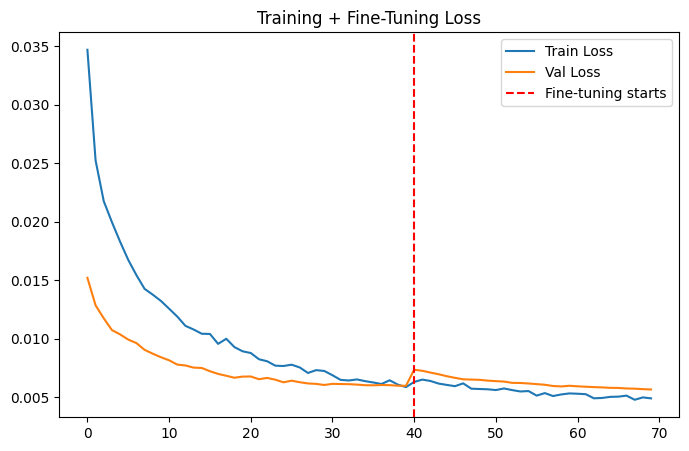

In [ ]:
def plot_combined(h1, h2):
    loss = h1.history["loss"] + h2.history["loss"]
    val_loss = h1.history["val_loss"] + h2.history["val_loss"]

    plt.figure(figsize=(8,5))
    plt.plot(loss, label="Train Loss")
    plt.plot(val_loss, label="Val Loss")
    plt.axvline(len(h1.history["loss"]), color="r", linestyle="--", label="Fine-tuning starts")
    plt.legend()
    plt.title("Training + Fine-Tuning Loss")
    plt.show()

plot_combined(history1, history2)


In [ ]:
model.save("weapon_detector_final.keras")
print("model saved successfully!")

model saved successfully!
